# How to transform data into factors

Based on a conceptual understanding of key factor categories, their rationale and popular metrics, a key task is to identify new factors that may better capture the risks embodied by the return drivers laid out previously, or to find new ones. 

In either case, it will be important to compare the performance of innovative factors to that of known factors to identify incremental signal gains.

We create the dataset here and store it in our [data](../data) folder to facilitate reuse in later chapters.

## Imports & Settings

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

from datetime import datetime
import pandas as pd
import pandas_datareader.data as web

# replaces pyfinance.ols.PandasRollingOLS (no longer maintained)
from statsmodels.regression.rolling import RollingOLS
import statsmodels.api as sm

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
sns.set_style('whitegrid')
idx = pd.IndexSlice

## Get Data

The `assets.h5` store can be generated using the the notebook [create_datasets](../data/create_datasets.ipynb) in the [data](../data) directory in the root directory of this repo for instruction to download the following dataset.

We load the Quandl stock price datasets covering the US equity markets 2000-18 using `pd.IndexSlice` to perform a slice operation on the `pd.MultiIndex`, select the adjusted close price and unpivot the column to convert the DataFrame to wide format with tickers in the columns and timestamps in the rows:

Set data store location:

In [4]:
DATA_STORE = './data/assets.h5'

In [33]:
START = 2010
END = 2024

In [41]:
with pd.HDFStore(DATA_STORE) as store:
    prices = store['merval/prices']
    stocks = store['merval/stocks'].loc[:, ['marketcap', 'ipoyear', 'sector']]

In [42]:
prices.head()

open      high       low     close     volume  \
date       ticker                                                       
2010-01-04 ALUA.BA  2.706321  2.761835  2.699382  2.741018  1043630.0   
           AUSO.BA  0.440000  0.440000  0.440000  0.440000        0.0   
           BBAR.BA  7.927357  7.995866  7.878423  7.956718    98059.0   
           BHIP.BA  1.470000  1.530000  1.470000  1.510000   278841.0   
           BMA.BA   6.547999  6.786108  6.547999  6.637290   208848.0   

                    ex-dividend  split_ratio  adj_open  adj_high   adj_low  \
date       ticker                                                            
2010-01-04 ALUA.BA            0            1  2.706321  2.761835  2.699382   
           AUSO.BA            0            1  0.440000  0.440000  0.440000   
           BBAR.BA            0            1  7.927357  7.995866  7.878423   
           BHIP.BA            0            1  1.470000  1.530000  1.470000   
           BMA.BA             0            1  6.547999  6.786108  6.547999   

                    adj_close  adj_volume  
date       ticker                          
2010-01-04 ALUA.BA   1.947371   1043630.0  
           AUSO.BA   0.229057         0.0  
           BBAR.BA   5.108605     98059.0  
           BHIP.BA   1.302655    278841.0  
           BMA.BA    4.105229    208848.0

In [8]:
stocks.info()

<class 'pandas.core.frame.DataFrame'>
Index: 62 entries, ALUA.BA to TGLT.BA
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   marketcap  59 non-null     float64
 1   ipoyear    62 non-null     int64  
 2   sector     59 non-null     object 
dtypes: float64(1), int64(1), object(1)
memory usage: 1.9+ KB


### Keep data with stock info

Remove `stocks` duplicates and align index names for later joining.

In [9]:
stocks = stocks[~stocks.index.duplicated()]
stocks.index.name = 'ticker'

Get tickers with both price information and metdata

In [10]:
shared = prices.columns.intersection(stocks.index)

In [11]:
stocks = stocks.loc[shared, :]
stocks.info()

<class 'pandas.core.frame.DataFrame'>
Index: 58 entries, ALUA.BA to YPFD.BA
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   marketcap  58 non-null     float64
 1   ipoyear    58 non-null     int64  
 2   sector     58 non-null     object 
dtypes: float64(1), int64(1), object(1)
memory usage: 1.8+ KB


In [12]:
prices = prices.loc[:, shared]
prices.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2201 entries, 2010-01-04 to 2018-12-31
Data columns (total 58 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   ALUA.BA   2198 non-null   float64
 1   AUSO.BA   2198 non-null   float64
 2   BBAR.BA   2198 non-null   float64
 3   BHIP.BA   2198 non-null   float64
 4   BMA.BA    2198 non-null   float64
 5   BOLT.BA   2198 non-null   float64
 6   BPAT.BA   2198 non-null   float64
 7   BYMA.BA   371 non-null    float64
 8   CADO.BA   2198 non-null   float64
 9   CAPX.BA   2198 non-null   float64
 10  CARC.BA   1942 non-null   float64
 11  CECO2.BA  2198 non-null   float64
 12  CELU.BA   2198 non-null   float64
 13  CEPU.BA   2201 non-null   float64
 14  CGPA2.BA  2198 non-null   float64
 15  COME.BA   2198 non-null   float64
 16  CRES.BA   2198 non-null   float64
 17  CTIO.BA   2198 non-null   float64
 18  DGCU2.BA  2198 non-null   float64
 19  DOME.BA   2198 non-null   float64
 20  DYCA.BA   21

In [13]:
assert prices.shape[1] == stocks.shape[0]

## Create monthly return series

To reduce training time and experiment with strategies for longer time horizons, we convert the business-daily data to month-end frequency using the available adjusted close price:

In [14]:
monthly_prices = prices.resample('M').last()

To capture time series dynamics that reflect, for example, momentum patterns, we compute historical returns using the method `.pct_change(n_periods)`, that is, returns over various monthly periods as identified by lags.

We then convert the wide result back to long format with the `.stack()` method, use `.pipe()` to apply the `.clip()` method to the resulting `DataFrame`, and winsorize returns at the [1%, 99%] levels; that is, we cap outliers at these percentiles.

Finally, we normalize returns using the geometric average. After using `.swaplevel()` to change the order of the `MultiIndex` levels, we obtain compounded monthly returns for six periods ranging from 1 to 12 months:

In [43]:
monthly_prices.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 108 entries, 2010-01-31 to 2018-12-31
Freq: M
Data columns (total 58 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   ALUA.BA   108 non-null    float64
 1   AUSO.BA   108 non-null    float64
 2   BBAR.BA   108 non-null    float64
 3   BHIP.BA   108 non-null    float64
 4   BMA.BA    108 non-null    float64
 5   BOLT.BA   108 non-null    float64
 6   BPAT.BA   108 non-null    float64
 7   BYMA.BA   19 non-null     float64
 8   CADO.BA   108 non-null    float64
 9   CAPX.BA   108 non-null    float64
 10  CARC.BA   108 non-null    float64
 11  CECO2.BA  108 non-null    float64
 12  CELU.BA   108 non-null    float64
 13  CEPU.BA   108 non-null    float64
 14  CGPA2.BA  108 non-null    float64
 15  COME.BA   108 non-null    float64
 16  CRES.BA   108 non-null    float64
 17  CTIO.BA   108 non-null    float64
 18  DGCU2.BA  108 non-null    float64
 19  DOME.BA   108 non-null    float64
 20  DYCA.

In [16]:
outlier_cutoff = 0.01
data = pd.DataFrame()
lags = [1, 2, 3, 6, 9, 12]
for lag in lags:
    data[f'return_{lag}m'] = (monthly_prices
                           .pct_change(lag)
                           .stack()
                           .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),
                                                  upper=x.quantile(1-outlier_cutoff)))
                           .add(1)
                           .pow(1/lag)
                           .sub(1)
                           )
data = data.swaplevel().dropna()
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 5073 entries, ('ALUA.BA', Timestamp('2011-01-31 00:00:00')) to ('YPFD.BA', Timestamp('2018-12-31 00:00:00'))
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   return_1m   5073 non-null   float64
 1   return_2m   5073 non-null   float64
 2   return_3m   5073 non-null   float64
 3   return_6m   5073 non-null   float64
 4   return_9m   5073 non-null   float64
 5   return_12m  5073 non-null   float64
dtypes: float64(6)
memory usage: 255.2+ KB


## Drop stocks with less than 10 yrs of returns

In [17]:
min_obs = 120
nobs = data.groupby(level='ticker').size()
keep = nobs[nobs>min_obs].index

data = data.loc[idx[keep,:], :]
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 0 entries
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   return_1m   0 non-null      float64
 1   return_2m   0 non-null      float64
 2   return_3m   0 non-null      float64
 3   return_6m   0 non-null      float64
 4   return_9m   0 non-null      float64
 5   return_12m  0 non-null      float64
dtypes: float64(6)
memory usage: 7.5+ KB


In [18]:
data.describe()

,return_1m,return_2m,return_3m,return_6m,return_9m,return_12m
count,0.0,0.0,0.0,0.0,0.0,0.0
mean,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN
max,NaN,NaN,NaN,NaN,NaN,NaN


ValueError: The condensed distance matrix must contain only finite values.

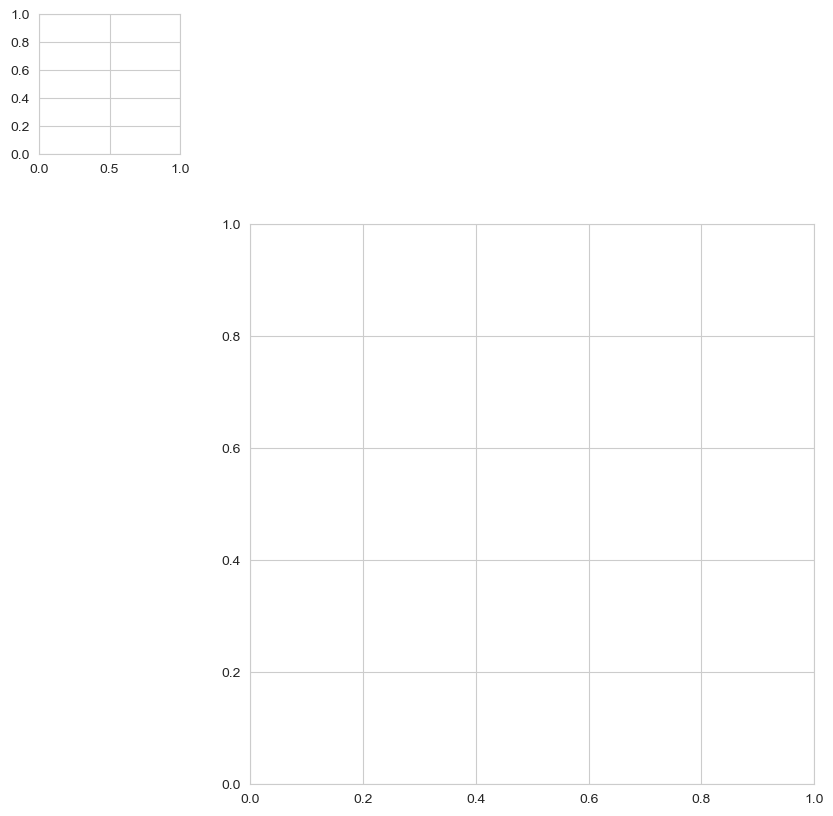

In [21]:
# cmap = sns.diverging_palette(10, 220, as_cmap=True)
sns.clustermap(data.corr('spearman'), annot=True, center=0, cmap='Blues');

We are left with 1,670 tickers.

In [22]:
data.index.get_level_values('ticker').nunique()

0

## Rolling Factor Betas

We will introduce the Fama—French data to estimate the exposure of assets to common risk factors using linear regression in [Chapter 9, Time Series Models](../09_time_series_models).

The five Fama—French factors, namely market risk, size, value, operating profitability, and investment have been shown empirically to explain asset returns and are commonly used to assess the risk/return profile of portfolios. Hence, it is natural to include past factor exposures as financial features in models that aim to predict future returns.

We can access the historical factor returns using the `pandas-datareader` and estimate historical exposures using the `RollingOLS` rolling linear regression functionality in the `statsmodels` library as follows:

Use Fama-French research factors to estimate the factor exposures of the stock in the dataset to the 5 factors market risk, size, value, operating profitability and investment.

In [23]:
factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']
factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3', 'famafrench', start='2000')[0].drop('RF', axis=1)
factor_data.index = factor_data.index.to_timestamp()
factor_data = factor_data.resample('M').last().div(100)
factor_data.index.name = 'date'
factor_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 293 entries, 2000-01-31 to 2024-05-31
Freq: M
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Mkt-RF  293 non-null    float64
 1   SMB     293 non-null    float64
 2   HML     293 non-null    float64
 3   RMW     293 non-null    float64
 4   CMA     293 non-null    float64
dtypes: float64(5)
memory usage: 13.7 KB


In [24]:
factor_data = factor_data.join(data['return_1m']).sort_index()
factor_data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 0 entries
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Mkt-RF     0 non-null      float64
 1   SMB        0 non-null      float64
 2   HML        0 non-null      float64
 3   RMW        0 non-null      float64
 4   CMA        0 non-null      float64
 5   return_1m  0 non-null      float64
dtypes: float64(6)
memory usage: 13.0+ KB


In [25]:
T = 24
betas = (factor_data.groupby(level='ticker',
                             group_keys=False)
         .apply(lambda x: RollingOLS(endog=x.return_1m,
                                     exog=sm.add_constant(x.drop('return_1m', axis=1)),
                                     window=min(T, x.shape[0]-1))
                .fit(params_only=True)
                .params
                .drop('const', axis=1)))

In [26]:
betas.describe().join(betas.sum(1).describe().to_frame('total'))

,Mkt-RF,SMB,HML,RMW,CMA,return_1m,total
count,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,NaN,NaN,NaN,NaN,NaN,NaN,NaN


ValueError: The condensed distance matrix must contain only finite values.

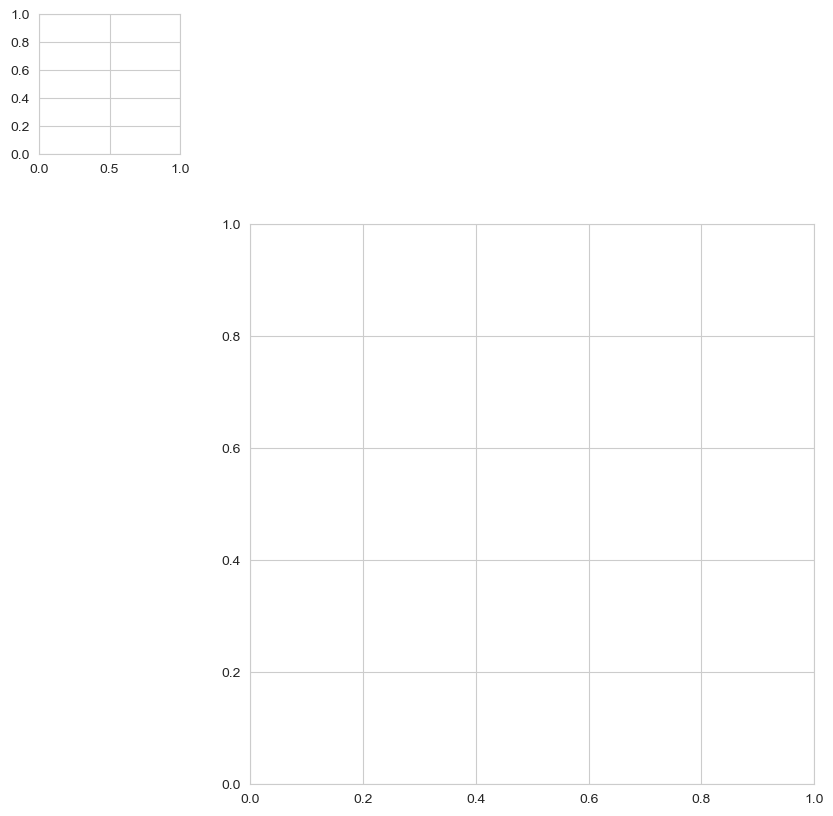

In [27]:
cmap = sns.diverging_palette(10, 220, as_cmap=True)
sns.clustermap(betas.corr(), annot=True, cmap=cmap, center=0);

In [29]:
data

,,return_1m,return_2m,return_3m,return_6m,return_9m,return_12m
ticker,date,,,,,,


In [28]:
data = (data
        .join(betas
              .groupby(level='ticker')
              .shift()))
data.info()

ValueError: columns overlap but no suffix specified: Index(['return_1m'], dtype='object')

### Impute mean for missing factor betas

In [ ]:
data.loc[:, factors] = data.groupby('ticker')[factors].apply(lambda x: x.fillna(x.mean()))
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 360752 entries, ('A', Timestamp('2001-01-31 00:00:00', freq='M')) to ('ZUMZ', Timestamp('2018-03-31 00:00:00', freq='M'))
Data columns (total 11 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   return_1m   360752 non-null  float64
 1   return_2m   360752 non-null  float64
 2   return_3m   360752 non-null  float64
 3   return_6m   360752 non-null  float64
 4   return_9m   360752 non-null  float64
 5   return_12m  360752 non-null  float64
 6   Mkt-RF      360752 non-null  float64
 7   SMB         360752 non-null  float64
 8   HML         360752 non-null  float64
 9   RMW         360752 non-null  float64
 10  CMA         360752 non-null  float64
dtypes: float64(11)
memory usage: 39.8+ MB


## Momentum factors

We can use these results to compute momentum factors based on the difference between returns over longer periods and the most recent monthly return, as well as for the difference between 3 and 12 month returns as follows:

In [ ]:
for lag in [2,3,6,9,12]:
    data[f'momentum_{lag}'] = data[f'return_{lag}m'].sub(data.return_1m)
data[f'momentum_3_12'] = data[f'return_12m'].sub(data.return_3m)

## Date Indicators

In [ ]:
dates = data.index.get_level_values('date')
data['year'] = dates.year
data['month'] = dates.month

## Lagged returns

To use lagged values as input variables or features associated with the current observations, we use the .shift() method to move historical returns up to the current period:

In [ ]:
for t in range(1, 7):
    data[f'return_1m_t-{t}'] = data.groupby(level='ticker').return_1m.shift(t)
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 360752 entries, ('A', Timestamp('2001-01-31 00:00:00', freq='M')) to ('ZUMZ', Timestamp('2018-03-31 00:00:00', freq='M'))
Data columns (total 25 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   return_1m      360752 non-null  float64
 1   return_2m      360752 non-null  float64
 2   return_3m      360752 non-null  float64
 3   return_6m      360752 non-null  float64
 4   return_9m      360752 non-null  float64
 5   return_12m     360752 non-null  float64
 6   Mkt-RF         360752 non-null  float64
 7   SMB            360752 non-null  float64
 8   HML            360752 non-null  float64
 9   RMW            360752 non-null  float64
 10  CMA            360752 non-null  float64
 11  momentum_2     360752 non-null  float64
 12  momentum_3     360752 non-null  float64
 13  momentum_6     360752 non-null  float64
 14  momentum_9     360752 non-null  float64
 15  momentum_12    360752 non

## Target: Holding Period Returns

Similarly, to compute returns for various holding periods, we use the normalized period returns computed previously and shift them back to align them with the current financial features

In [ ]:
for t in [1,2,3,6,12]:
    data[f'target_{t}m'] = data.groupby(level='ticker')[f'return_{t}m'].shift(-t)

In [ ]:
cols = ['target_1m',
        'target_2m',
        'target_3m', 
        'return_1m',
        'return_2m',
        'return_3m',
        'return_1m_t-1',
        'return_1m_t-2',
        'return_1m_t-3']

data[cols].dropna().sort_index().head(10)

target_1m  target_2m  target_3m  return_1m  return_2m  \
ticker date                                                                
A      2001-04-30  -0.140220  -0.087246  -0.098192   0.269444   0.040966   
       2001-05-31  -0.031008  -0.076414  -0.075527  -0.140220   0.044721   
       2001-06-30  -0.119692  -0.097014  -0.155847  -0.031008  -0.087246   
       2001-07-31  -0.073750  -0.173364  -0.080114  -0.119692  -0.076414   
       2001-08-31  -0.262264  -0.083279   0.009593  -0.073750  -0.097014   
       2001-09-30   0.139130   0.181052   0.134010  -0.262264  -0.173364   
       2001-10-31   0.224517   0.131458   0.108697   0.139130  -0.083279   
       2001-11-30   0.045471   0.054962   0.045340   0.224517   0.181052   
       2001-12-31   0.064539   0.045275   0.070347   0.045471   0.131458   
       2002-01-31   0.026359   0.073264  -0.003306   0.064539   0.054962   

                   return_3m  return_1m_t-1  return_1m_t-2  return_1m_t-3  
ticker date                                                                
A      2001-04-30  -0.105747      -0.146389      -0.329564      -0.003653  
       2001-05-31  -0.023317       0.269444      -0.146389      -0.329564  
       2001-06-30   0.018842      -0.140220       0.269444      -0.146389  
       2001-07-31  -0.098192      -0.031008      -0.140220       0.269444  
       2001-08-31  -0.075527      -0.119692      -0.031008      -0.140220  
       2001-09-30  -0.155847      -0.073750      -0.119692      -0.031008  
       2001-10-31  -0.080114      -0.262264      -0.073750      -0.119692  
       2001-11-30   0.009593       0.139130      -0.262264      -0.073750  
       2001-12-31   0.134010       0.224517       0.139130      -0.262264  
       2002-01-31   0.108697       0.045471       0.224517       0.139130

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 360752 entries, ('A', Timestamp('2001-01-31 00:00:00', freq='M')) to ('ZUMZ', Timestamp('2018-03-31 00:00:00', freq='M'))
Data columns (total 30 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   return_1m      360752 non-null  float64
 1   return_2m      360752 non-null  float64
 2   return_3m      360752 non-null  float64
 3   return_6m      360752 non-null  float64
 4   return_9m      360752 non-null  float64
 5   return_12m     360752 non-null  float64
 6   Mkt-RF         360752 non-null  float64
 7   SMB            360752 non-null  float64
 8   HML            360752 non-null  float64
 9   RMW            360752 non-null  float64
 10  CMA            360752 non-null  float64
 11  momentum_2     360752 non-null  float64
 12  momentum_3     360752 non-null  float64
 13  momentum_6     360752 non-null  float64
 14  momentum_9     360752 non-null  float64
 15  momentum_12    360752 non

## Create age proxy

We use quintiles of IPO year as a proxy for company age.

In [ ]:
data = (data
        .join(pd.qcut(stocks.ipoyear, q=5, labels=list(range(1, 6)))
              .astype(float)
              .fillna(0)
              .astype(int)
              .to_frame('age')))
data.age = data.age.fillna(-1)

## Create dynamic size proxy

We use the marketcap information from the NASDAQ ticker info to create a size proxy.

In [ ]:
stocks.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2412 entries, A to ZUMZ
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   marketcap  2407 non-null   float64
 1   ipoyear    1065 non-null   float64
 2   sector     2372 non-null   object 
dtypes: float64(2), object(1)
memory usage: 139.9+ KB


Market cap information is tied to currrent prices. We create an adjustment factor to have the values reflect lower historical prices for each individual stock:

In [ ]:
size_factor = (monthly_prices
               .loc[data.index.get_level_values('date').unique(),
                    data.index.get_level_values('ticker').unique()]
               .sort_index(ascending=False)
               .pct_change()
               .fillna(0)
               .add(1)
               .cumprod())
size_factor.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 207 entries, 2018-03-31 to 2001-01-31
Columns: 1838 entries, A to ZUMZ
dtypes: float64(1838)
memory usage: 2.9 MB


In [ ]:
msize = (size_factor
         .mul(stocks
              .loc[size_factor.columns, 'marketcap'])).dropna(axis=1, how='all')

### Create Size indicator as deciles per period

Compute size deciles per month:

In [ ]:
data['msize'] = (msize
                 .apply(lambda x: pd.qcut(x, q=10, labels=list(range(1, 11)))
                        .astype(int), axis=1)
                 .stack()
                 .swaplevel())
data.msize = data.msize.fillna(-1)

## Combine data

In [ ]:
data = data.join(stocks[['sector']])
data.sector = data.sector.fillna('Unknown')

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 360752 entries, ('A', Timestamp('2001-01-31 00:00:00', freq='M')) to ('ZUMZ', Timestamp('2018-03-31 00:00:00', freq='M'))
Data columns (total 33 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   return_1m      360752 non-null  float64
 1   return_2m      360752 non-null  float64
 2   return_3m      360752 non-null  float64
 3   return_6m      360752 non-null  float64
 4   return_9m      360752 non-null  float64
 5   return_12m     360752 non-null  float64
 6   Mkt-RF         360752 non-null  float64
 7   SMB            360752 non-null  float64
 8   HML            360752 non-null  float64
 9   RMW            360752 non-null  float64
 10  CMA            360752 non-null  float64
 11  momentum_2     360752 non-null  float64
 12  momentum_3     360752 non-null  float64
 13  momentum_6     360752 non-null  float64
 14  momentum_9     360752 non-null  float64
 15  momentum_12    360752 non

## Store data

We will use the data again in several later chapters, starting in [Chapter 7 on Linear Models](../07_linear_models).

In [ ]:
with pd.HDFStore(DATA_STORE) as store:
    store.put('engineered_features', data.sort_index().loc[idx[:, :datetime(2018, 3, 1)], :])
    print(store.info())

<class 'pandas.io.pytables.HDFStore'>
File path: ../data/assets.h5
/engineered_features                        frame        (shape->[358914,33])                                                                
/quandl/wiki/prices                         frame        (shape->[15389314,12])                                                              
/quandl/wiki/stocks                         frame        (shape->[1,2])                                                                      
/sp500/fred                                 frame        (shape->[2609,1])                                                                   
/sp500/sp500_stooq                          frame        (shape->[17700,5])                                                                  
/sp500/stocks                               frame        (shape->[1,7])                                                                      
/sp500/stooq                                frame        (shape->[17700,5])      

## Create Dummy variables

For most models, we need to encode categorical variables as 'dummies' (one-hot encoding):

In [ ]:
dummy_data = pd.get_dummies(data,
                            columns=['year','month', 'msize', 'age',  'sector'],
                            prefix=['year','month', 'msize', 'age', ''],
                            prefix_sep=['_', '_', '_', '_', ''])
dummy_data = dummy_data.rename(columns={c:c.replace('.0', '') for c in dummy_data.columns})
dummy_data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 360752 entries, ('A', Timestamp('2001-01-31 00:00:00', freq='M')) to ('ZUMZ', Timestamp('2018-03-31 00:00:00', freq='M'))
Data columns (total 88 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   return_1m              360752 non-null  float64
 1   return_2m              360752 non-null  float64
 2   return_3m              360752 non-null  float64
 3   return_6m              360752 non-null  float64
 4   return_9m              360752 non-null  float64
 5   return_12m             360752 non-null  float64
 6   Mkt-RF                 360752 non-null  float64
 7   SMB                    360752 non-null  float64
 8   HML                    360752 non-null  float64
 9   RMW                    360752 non-null  float64
 10  CMA                    360752 non-null  float64
 11  momentum_2             360752 non-null  float64
 12  momentum_3             360752 non-null  float64
